# Testing workshop for Bede

In [1]:
! echo $HOSTNAME

login2.bede.dur.ac.uk


In [2]:
! arch

ppc64le


In [3]:
! date

Fri 20 Jan 15:21:25 GMT 2023


In [4]:
import numpy as np
size = 4096 * 4096
input = np.random.random(size).astype(np.float32)

In [5]:
%timeit -n 1 -r 1 output = np.sort(input)


1.84 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
from cupyx.profiler import benchmark
import cupy as cp
input_gpu = cp.asarray(input)
execution_gpu = benchmark(cp.sort, (input_gpu,), n_repeat=10)
gpu_avg_time = np.average(execution_gpu.gpu_times)
print(f"{gpu_avg_time:.6f} s")


0.001619 s


In [7]:
speedup = 1.83 / 0.008949
print(speedup)


204.49212202480723


In [8]:
import numpy as np

# Construct an image with repeated delta functions
deltas = np.zeros((2048, 2048))
deltas[8::16,8::16] = 1


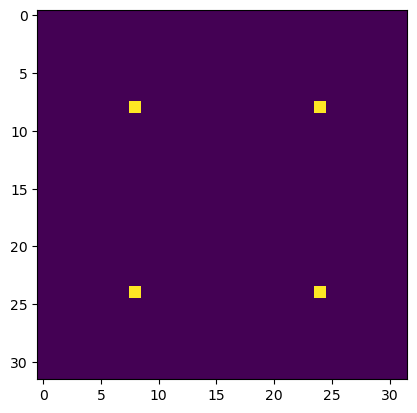

In [9]:
import pylab as pyl
# Necessary command to render a matplotlib image in a Jupyter notebook.
%matplotlib inline

# Display the image
# You can zoom in using the menu in the window that will appear
pyl.imshow(deltas[0:32, 0:32])
pyl.show()


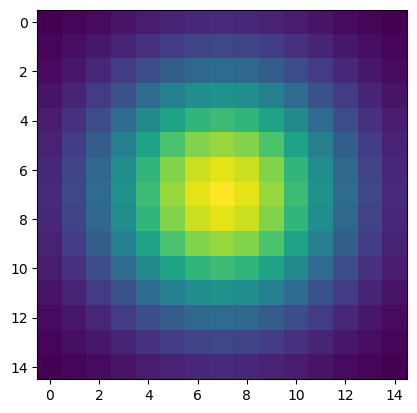

In [10]:
x, y = np.meshgrid(np.linspace(-2, 2, 15), np.linspace(-2, 2, 15))
dst = np.sqrt(x*x + y*y)
sigma = 1
muu = 0.000
gauss = np.exp(-((dst-muu)**2/(2.0 * sigma**2)))
pyl.imshow(gauss)
pyl.show()


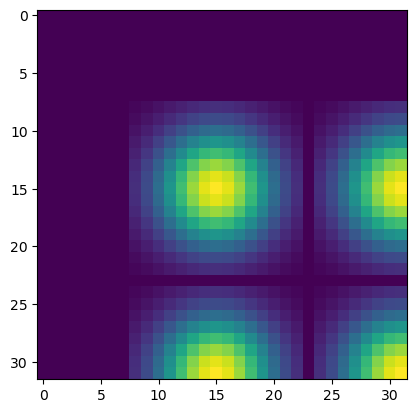

3.05 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [11]:
from scipy.signal import convolve2d as convolve2d_cpu

convolved_image_using_CPU = convolve2d_cpu(deltas, gauss)
pyl.imshow(convolved_image_using_CPU[0:32, 0:32])
pyl.show()
%timeit -n 1 -r 1 convolve2d_cpu(deltas, gauss)

In [12]:
import cupy as cp

deltas_gpu = cp.asarray(deltas)
gauss_gpu = cp.asarray(gauss)

In [13]:
from cupyx.scipy.signal import convolve2d as convolve2d_gpu

convolved_image_using_GPU = convolve2d_gpu(deltas_gpu, gauss_gpu)
%timeit -n 7 -r 1 convolved_image_using_GPU = convolve2d_gpu(deltas_gpu, gauss_gpu)

300 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 7 loops each)


In [14]:
from cupyx.profiler import benchmark

execution_gpu = benchmark(convolve2d_gpu, (deltas_gpu, gauss_gpu), n_repeat=10)

In [15]:
gpu_avg_time = np.average(execution_gpu.gpu_times)
print(f"{gpu_avg_time:.6f} s")

0.004331 s


In [16]:
np.allclose(convolved_image_using_GPU, convolved_image_using_CPU)

array(True)

In [17]:
convolve2d_cpu(deltas_gpu, gauss_gpu)

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [18]:
deltas_1d = deltas.ravel()
gauss_1d = gauss.diagonal()
%timeit -n 1 -r 1 np.convolve(deltas_1d, gauss_1d)

116 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
deltas_1d_gpu = cp.asarray(deltas_1d)
gauss_1d_gpu = cp.asarray(gauss_1d)

execution_gpu = benchmark(np.convolve, (deltas_1d_gpu, gauss_1d_gpu), n_repeat=10)
gpu_avg_time = np.average(execution_gpu.gpu_times)
print(f"{gpu_avg_time:.6f} s")

0.001938 s


## Real world astropy example

In [20]:
from astropy.io import fits

with fits.open("data/GMRT_image_of_Galactic_Center.fits") as hdul:
    data = hdul[0].data.byteswap().newbyteorder()

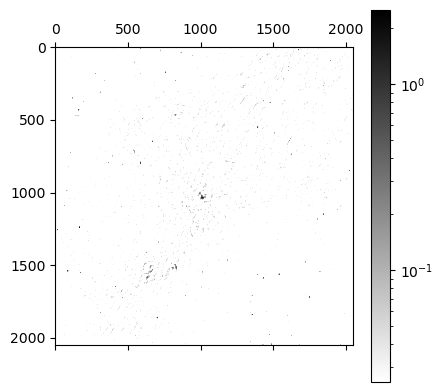

In [21]:
from matplotlib.colors import LogNorm

maxim = data.max()

pyl.matshow(data, cmap=pyl.cm.gray_r, norm=LogNorm(vmin = maxim/100, vmax=maxim))
pyl.colorbar()

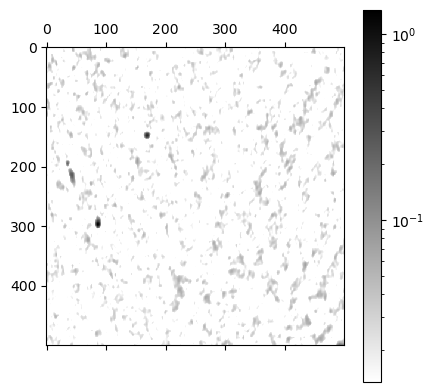

In [22]:
subimage = data[500:1000, 500:1000]
maxim_sub = subimage.max()
pyl.matshow(subimage, cmap=pyl.cm.gray_r, \
            norm=LogNorm(vmin = maxim_sub/100, vmax=maxim_sub))
pyl.colorbar()


In [23]:
mean_ = data.mean()
median_ = np.median(data)
stddev_ = np.std(data)
max_ = np.amax(data)
print(f"mean = {mean_:.3e}, median = {median_:.3e}, sttdev = {stddev_:.3e},\
maximum = {max_:.3e}")

mean = 3.898e-04, median = 1.571e-05, sttdev = 1.993e-02,maximum = 2.506e+00


In [24]:
# Flattening our 2D data first makes subsequent steps easier.
data_flat = data.ravel()
# Here is a kappa, sigma clipper for the CPU
def kappa_sigma_clipper(data_flat):
    while True:
         med = np.median(data_flat)
         std = np.std(data_flat)
         clipped_lower = data_flat.compress(data_flat > med - 3 * std)
         clipped_both = clipped_lower.compress(clipped_lower < med + 3 * std)
         if len(clipped_both) == len(data_flat):
             break
         data_flat = clipped_both  
    return data_flat

data_clipped = kappa_sigma_clipper(data_flat)
timing_ks_clipping_cpu = %timeit -o kappa_sigma_clipper(data_flat)
fastest_ks_clipping_cpu = timing_ks_clipping_cpu.best
print(f"Fastest CPU ks clipping time = {1000 * fastest_ks_clipping_cpu:.3e} ms.")

780 ms ± 6.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Fastest CPU ks clipping time = 7.698e+02 ms.


In [25]:
mean_ = data_clipped.mean()
median_ = np.median(data_clipped)
stddev_ = np.std(data_clipped)
max_ = np.amax(data_clipped)
print(f"mean = {mean_:.3e}, median = {median_:.3e}, sttdev = {stddev_:.3e},\
maximum = {max_:.3e}")

mean = -1.945e-06, median = -9.796e-06, sttdev = 1.334e-02,maximum = 4.000e-02


In [26]:
stddev_gpu_ = np.std(data_gpu_clipped)
print(f"standard deviation of background_noise = {stddev_:.4f} Jy/beam")


NameError: name 'data_gpu_clipped' is not defined

In [ ]:
threshold = 5 * stddev_
segmented_image = np.where(data > threshold, 1,  0)
timing_segmentation_CPU = %timeit -o np.where(data > threshold, 1,  0)
fastest_segmentation_CPU = timing_segmentation_CPU.best 
print(f"Fastest CPU segmentation time = {1000 * fastest_segmentation_CPU:.3e} ms.")

In [ ]:
from scipy.ndimage import label
labelled_image = np.empty(data.shape)
number_of_sources_in_image = label(segmented_image, output = labelled_image)
sigma_unicode = "\u03C3"
print(f"The number of sources in the image at the 5{sigma_unicode} level is \
{number_of_sources_in_image}.")

timing_CCL_CPU = %timeit -o label(segmented_image, output = labelled_image)
fastest_CCL_CPU = timing_CCL_CPU.best
print(f"Fastest CPU CCL time = {1000 * fastest_CCL_CPU:.3e} ms.")

In [ ]:
print(f"These are all the pixel values we can find in the labelled image: \
{np.unique(labelled_image)}")


In [ ]:
from scipy.ndimage import center_of_mass, sum_labels
all_positions = center_of_mass(data, labelled_image, \
                               range(1, number_of_sources_in_image+1))
all_integrated_fluxes = sum_labels(data, labelled_image, \
                               range(1, number_of_sources_in_image+1))

print (f'These are the ten highest integrated fluxes of the sources in my image: \
{np.sort(all_integrated_fluxes)[-10:]}')


In [ ]:
%%timeit -o
all_positions = center_of_mass(data, labelled_image, \
                               range(1, number_of_sources_in_image+1))
all_integrated_fluxes = sum_labels(data, labelled_image, \
                               range(1, number_of_sources_in_image+1))


In [ ]:
timing_source_measurements_CPU = _
fastest_source_measurements_CPU = timing_source_measurements_CPU.best
print(f"Fastest CPU set of source measurements = \
{1000 * fastest_source_measurements_CPU:.3e} ms.")


In [ ]:
# Now on the GPU
from cupyx.scipy.ndimage import center_of_mass as com_gpu
from cupyx.scipy.ndimage import sum_labels as sl_gpu

timing_position_measurements_GPU = benchmark(com_gpu, (data_gpu, labelled_image_gpu, \
                                      cp.arange(1, number_of_sources_in_image+1)),
                                      n_repeat =10)
fastest_position_measurements_GPU = np.amin(timing_position_measurements_GPU.gpu_times)
timing_flux_measurements_GPU = benchmark(sl_gpu, (data_gpu, labelled_image_gpu, \
                                      cp.arange(1, number_of_sources_in_image+1)),
                                      n_repeat =10)
fastest_flux_measurements_GPU = np.amin(timing_flux_measurements_GPU.gpu_times)
fastest_source_measurements_GPU = fastest_position_measurements_GPU + \
                                  fastest_flux_measurements_GPU
print(f"Fastest source measurements on the GPU take \
 {1000 * fastest_source_measurements_GPU:.3e} ms")
print()
speedup_factor = fastest_source_measurements_CPU/fastest_source_measurements_GPU
print(f"The speedup factor for source measurements is: {speedup_factor:.3e}")
